In [155]:
import pandas as pd
df = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/bbc_data_audio_transcriptions.csv")

In [157]:
df['publish_date'] = pd.to_datetime(df['publish_date'], utc = True)
df['Year'] = df['publish_date'].dt.year
df['Month'] = df['publish_date'].dt.month_name()

In [158]:
df_valid = df[pd.to_datetime(df['publish_date'], errors='coerce').notna()]
df_valid = df[df["transcription"].notna()]
df_valid = df_valid[df_valid['transcription'].apply(lambda x: isinstance(x, str) and x.strip() != "")] 

In [159]:
# Group by Year and Month, combining texts into lists
grouped_data = df_valid.groupby(['Year', 'Month'])['transcription'].apply(list).reset_index()

In [17]:
# Find rows where 'transcription' contains non-string values
non_string_rows = grouped_data[~grouped_data['transcription'].apply(lambda x: isinstance(x, str))]

# Display the problematic rows
print(non_string_rows)

    Year      Month                                      transcription
0   2023      April  [ The group has begun a three-day official vis...
1   2023     August  [ A whopper of a story, a US judge says Burger...
2   2023   December  [ The UN says around 300 people die every year...
3   2023       July  [ Let's go to Russia now with the Defence Mini...
4   2023       June  [ Now, Ukraine's president Zelensky has told t...
5   2023        May  [ While a group of top experts and CEOs in the...
6   2023   November  [ Now let's move on to COP28 where world leade...
7   2023    October  [ Now let's focus on a warning that's come fro...
8   2023  September  [ Police in Pakistan say at least 52 people ha...
9   2024      April  [ But let's begin with that breaking news out ...
10  2024     August  [ Donald Trump has accused the US Department o...
11  2024   February  [ More than 100 people are reported to have be...
12  2024    January  [ Russia's President Putin has launched his el...
13  20

In [18]:
# Define a function to split texts into chunks
def split_text_into_chunks(text, max_length=500):
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

# Apply chunking to each transcription within each bucket
grouped_data['Chunks'] = grouped_data['transcription'].apply(
    lambda texts: [chunk for text in texts for chunk in split_text_into_chunks(text)]
)

In [20]:
# Explode chunks into individual rows
exploded_data = grouped_data.explode('Chunks', ignore_index=True)

# Drop unnecessary columns for BERTopic
exploded_data_for_modeling = exploded_data[['Year', 'Month', 'Chunks']].dropna()

In [23]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic


# Define custom stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({"the", "and", "of", "to", "in", 
                                                  "is", "we", "this", "that", "for", 
                                                  "one", "two", "just", "its", "yes", 
                                                  "no", "it", 's', 'will', 'one', 'S', 
                                                  'u', 'U', 'say', 'bbc', 'people', 
                                                  'says', 'first', 'two', 's', 'u', 'yeah', 'now', 'well',
                                                  'think', 'know', 'thats', 'going', 'really', 'day', 'way',
                                                  'many', 'see', 'going', 'really', 'need', 'mean', 'lot', 
                                                  'moment', 'saying', 'still', 'new', 'want', 'dont', 'said', 'thing',
                                                  'theres', 'hes', 'right', 'theyre', 'course', 'di', 'much', 'come', 'weve',
                                                  'look', 'something', 'might', 'trying', 'actually', 'let', 'today',
                                                  'take', 'seen', 'go', 'yes', 'live', 'yn', 'ir', 'shes', 'im', 'ive'})

# Define custom stopwords
custom_stopwords2 = ["the", "and", "of", "to", "in", "is", "we", "this", "that", 
                    "for", "one", "two", "just", "its", "yes", "no", "it", 
                     's', 'will', 'one', 'S', 'u', 'U', 'say', 'bbc', 'people', 
                     'says', 'first', 'two', 's', 'u', 'yeah', 'now', 'well',
                     'think', 'know', 'thats', 'going', 'really', 'day', 'way',
                     'many', 'see', 'going', 'really', 'need', 'mean', 'lot', 
                     'moment', 'saying', 'still', 'new', 'want', 'dont', 'said', 'thing',
                     'theres', 'hes', 'right', 'theyre', 'course', 'di', 'much', 'come', 'weve',
                     'look', 'something', 'might', 'trying', 'actually', 'let', 'today',
                     'take', 'seen', 'go', 'yes', 'live', 'yn', 'ir', 'shes', 'im', 'ive']

# Preprocess text data to remove stopwords
def preprocess_text(text):
    words = text.split()
    return " ".join(word for word in words if word.lower() not in custom_stopwords)

# Apply preprocessing to your dataset
exploded_data_for_modeling['Processed_Chunks'] = exploded_data_for_modeling['Chunks'].apply(preprocess_text)
vectorizer_model = CountVectorizer(stop_words=custom_stopwords2)

# Fit BERTopic on the preprocessed text
model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = model.fit_transform(exploded_data_for_modeling['Processed_Chunks'])

## Generating topics, descriptions using OpenAI

In [24]:
all_topics = model.get_topics()
topic_words = {topic_id: [word for word, _ in words] for topic_id, words in all_topics.items()}

In [25]:
pseudo_documents = {topic_id: " ".join(words) for topic_id, words in topic_words.items()}

In [26]:
import openai
openai.api_key = ""

# Function to generate topic name and description
def generate_topic_name_description(topic_words):
    prompt = f"""The following words represent a topic: {', '.join(topic_words)}. 
    Based on these words, provide:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.

    Output:
    - Topic Name: 
    - Description:"""
    
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    return response.choices[0].message.content.strip()

In [27]:
# Generate topic names and descriptions
topic_names_descriptions = {}
for topic_id, words in topic_words.items():
    output = generate_topic_name_description(words)
    topic_names_descriptions[topic_id] = output

In [28]:
topic_names_descriptions

{-1: "- Topic Name: UK Children's Safety News \n- Description: This topic covers news and discussions related to children's safety in the UK, including incidents involving the police, car accidents, and annual statistics.",
 0: '- Topic Name: Israel-Gaza Conflict\n- Description: This topic revolves around the ongoing geopolitical struggle between Israel and Gaza, involving military clashes, hostage situations, and humanitarian aid issues. It also covers ceasefire attempts and the role of Hamas, a Palestinian political organization.',
 1: '- Topic Name: Russian-Ukrainian Political Conflict\n- Description: This topic covers the ongoing political and military tensions between Russia and Ukraine, involving key figures such as Russian President Putin and significant locations like Kiev and Moscow.',
 2: '- Topic Name: US Presidential Election 2020\n- Description: This topic encapsulates the key individuals, campaigns, and events pertaining to the 2020 Presidential Election in the United Sta

## Connecting the topics to ids

In [29]:
topic_names = {topic_id: desc.split("\n")[0].replace("- Topic Name: ", "").strip() 
               for topic_id, desc in topic_names_descriptions.items()}

In [30]:
# Add topic IDs and names to the dataset
exploded_data_for_modeling['Assigned_Topic_ID'] = topics
exploded_data_for_modeling['Assigned_Topic_Name'] = exploded_data_for_modeling['Assigned_Topic_ID'].map(topic_names)

In [32]:
exploded_data_for_modeling.head()

,Year,Month,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name
0,2023,April,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict
1,2023,April,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict
2,2023,April,Sudan's army has accused its rival paramilitar...,Sudan's army accused rival paramilitary rapid ...,17,Sudanese Conflict and Civil War
3,2023,April,Your live with BBC News. The European Space Ag...,News. European Space Agency's disabled astrona...,-1,UK Children's Safety News
4,2023,April,physical disability to go to space and address...,physical disability space address issues hopef...,-1,UK Children's Safety News


In [33]:
exploded_data_for_modeling['Date'] = pd.to_datetime(
    exploded_data_for_modeling['Year'].astype(str) + '-' + exploded_data_for_modeling['Month'].astype(str) + '-01'
)

In [35]:
exploded_data_for_modeling.head()

,Year,Month,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Date
0,2023,April,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict,2023-04-01
1,2023,April,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict,2023-04-01
2,2023,April,Sudan's army has accused its rival paramilitar...,Sudan's army accused rival paramilitary rapid ...,17,Sudanese Conflict and Civil War,2023-04-01
3,2023,April,Your live with BBC News. The European Space Ag...,News. European Space Agency's disabled astrona...,-1,UK Children's Safety News,2023-04-01
4,2023,April,physical disability to go to space and address...,physical disability space address issues hopef...,-1,UK Children's Safety News,2023-04-01


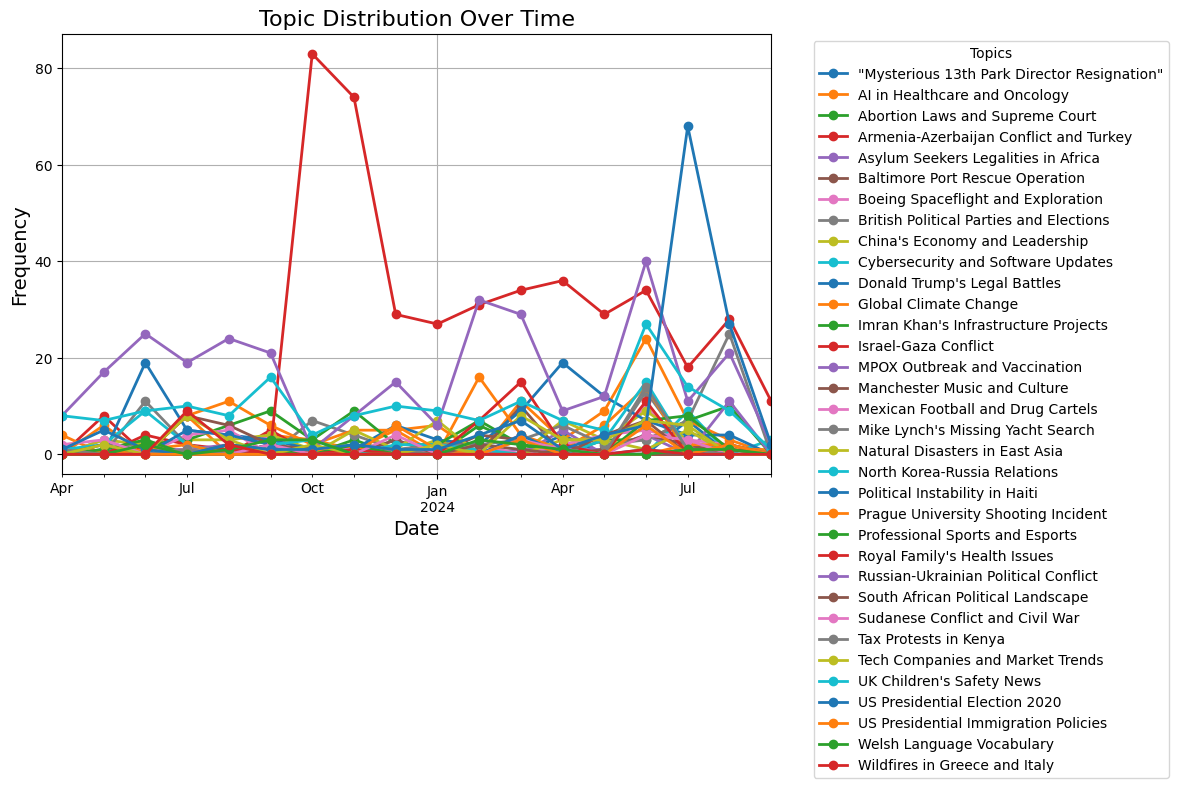

In [40]:
# Group by date and topic name to calculate frequency
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'Assigned_Topic_Name'])
    .size()
    .reset_index(name='Frequency')
)

# Pivot the data for easier plotting
pivoted_data = topic_frequencies.pivot(index='Date', columns='Assigned_Topic_Name', values='Frequency').fillna(0)

# Plot the data
pivoted_data.plot(kind='line', figsize=(12, 7), marker='o', linewidth=2)

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Larger groups

In [41]:
topic_names

{-1: "UK Children's Safety News",
 0: 'Israel-Gaza Conflict',
 1: 'Russian-Ukrainian Political Conflict',
 2: 'US Presidential Election 2020',
 3: "Donald Trump's Legal Battles",
 4: 'AI in Healthcare and Oncology',
 5: 'Global Climate Change',
 6: "Imran Khan's Infrastructure Projects",
 7: "Mike Lynch's Missing Yacht Search",
 8: 'Tech Companies and Market Trends',
 9: "China's Economy and Leadership",
 10: 'North Korea-Russia Relations',
 11: "Royal Family's Health Issues",
 12: 'Manchester Music and Culture',
 13: 'British Political Parties and Elections',
 14: 'Mexican Football and Drug Cartels',
 15: 'Natural Disasters in East Asia',
 16: 'Professional Sports and Esports',
 17: 'Sudanese Conflict and Civil War',
 18: 'MPOX Outbreak and Vaccination',
 19: 'Boeing Spaceflight and Exploration',
 20: 'South African Political Landscape',
 21: 'Welsh Language Vocabulary',
 22: 'Tax Protests in Kenya',
 23: 'Political Instability in Haiti',
 24: 'Prague University Shooting Incident',
 2

In [4]:
topic_groups = {
    "US-Related Politics": [2, 3, 26, 30, 31, 32],
    "UK Politics": [-1, 7, 13],
    "British culture": [11, 12, 21],
    "Russian War on Ukraine": [1],
    "Israeli-Gaza Conflict": [0],
    "Tech and Development": [4, 8, 19, 27],
    "Global Health and Climate Change Issues": [5, 15, 18, 28],
    "Russian Relations": [10],
    "China-related News": [9],
    "Sports": [16],
    "Other Global News": [6, 14, 17, 20, 22, 23, 24, 29], 
    "Armenia-Azerbaijan Conflict and Turkey": [25]
}

In [5]:
def assign_group(topic_id):
    for group, ids in topic_groups.items():
        if topic_id in ids:
            return group
    return "Other"

exploded_data_for_modeling["Group"] = exploded_data_for_modeling["Assigned_Topic_ID"].apply(assign_group)

In [186]:
import pandas as pd

# Ensure 'Date' column is in datetime format
exploded_data_for_modeling["Date"] = pd.to_datetime(exploded_data_for_modeling["Date"])

# Filter for "US-Related Politics" group and specific date ranges
filtered_data = exploded_data_for_modeling[
    (exploded_data_for_modeling["Group"] == "Russian War on Ukraine") &
    (
        #(exploded_data_for_modeling["Date"].dt.year == 2023) & (exploded_data_for_modeling["Date"].dt.month == 10) |
        (exploded_data_for_modeling["Date"].dt.year == 2024) & (exploded_data_for_modeling["Date"].dt.month.isin([4]))
    )
]

# Display some entries
filtered_data['Chunks'].iloc[9]

IndexError: single positional indexer is out-of-bounds

In [64]:
# List of topics you want to exclude
topics_to_exclude = ['Sports', "Tech and Development", "Pakistan-related News", "Mexico-related News", 
                     "Sudanese Conflict", "Prague shooting", "South African-related News", 
                     "Kenya's Protests", "Haiti-related News", "Prague shooting", "Asylum Seekers in Africa"]

# Filter the DataFrame to exclude rows with those topics
filtered_df = exploded_data_for_modeling[~exploded_data_for_modeling['Group'].isin(topics_to_exclude)]

# Check the result
print(filtered_df.head())


   Year  Month                                             Chunks  \
0  2023  April  The group has begun a three-day official visit...   
1  2023  April  from the cathedral in the capital Budapest. We...   
3  2023  April  Your live with BBC News. The European Space Ag...   
4  2023  April  physical disability to go to space and address...   
6  2023  April  What do we know about what services are functi...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  group begun three-day official visit Hungary, ...                  1   
1  cathedral capital Budapest. bring you, course,...                  1   
3  News. European Space Agency's disabled astrona...                 -1   
4  physical disability space address issues hopef...                 -1   
6  services functioning help able get, any? passe...                 -1   

                    Assigned_Topic_Name       Date                   Group  \
0  Russian-Ukrainian Political Conflict 2023-04-01  Russ

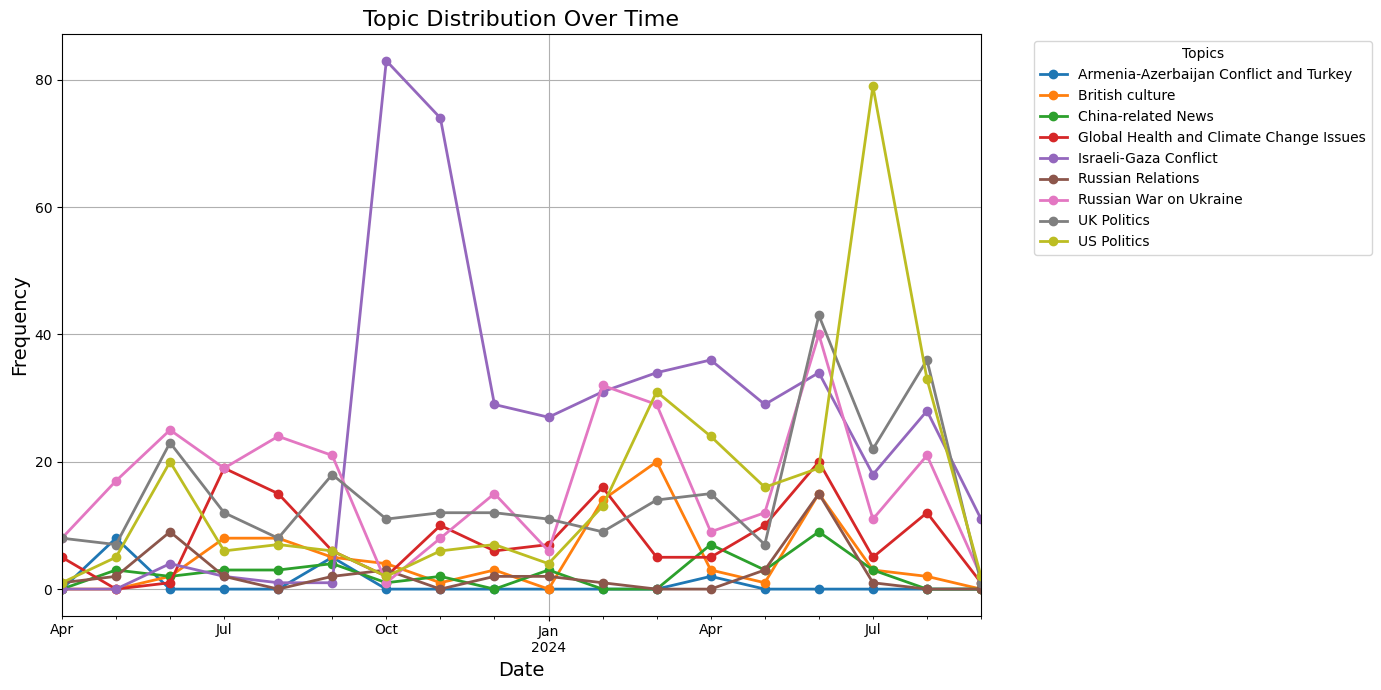

In [65]:
# Group by date and topic name to calculate frequency
topic_frequencies = (
    filtered_df
    .groupby(['Date', 'Group'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='Group', values='Frequency').fillna(0)
pivoted_data = pivoted_data.loc[:, pivoted_data.sum(axis=0) > 0]

pivoted_data.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)
plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

## Sentiment Analysis

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
from scipy.special import softmax
from tqdm import tqdm

In [7]:
exploded_data_for_modeling.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_scores.csv")

In [46]:
# Load the sentiment model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to calculate sentiment scores for a single text
def get_sentiment_scores(text):
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        scores = softmax(output[0][0].detach().numpy())
        return {config.id2label[i]: scores[i] for i in range(len(scores))}
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {"positive": None, "neutral": None, "negative": None}

# Apply sentiment analysis to the dataframe
tqdm.pandas()  # For progress bar
exploded_data_for_modeling['Sentiment_Scores'] = exploded_data_for_modeling['Processed_Chunks'].progress_apply(get_sentiment_scores)

# Extract scores into separate columns
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('positive'))
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('neutral'))
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('negative'))

# Drop the intermediate column if desired
exploded_data_for_modeling.drop(columns=['Sentiment_Scores'], inplace=True)

# Display the updated dataframe
print(exploded_data_for_modeling.head())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████| 2023/2023 [03:59<00:00,  8.45it/s]

   Year  Month                                             Chunks  \
0  2023  April  The group has begun a three-day official visit...   
1  2023  April  from the cathedral in the capital Budapest. We...   
2  2023  April  Sudan's army has accused its rival paramilitar...   
3  2023  April  Your live with BBC News. The European Space Ag...   
4  2023  April  physical disability to go to space and address...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  group begun three-day official visit Hungary, ...                  1   
1  cathedral capital Budapest. bring you, course,...                  1   
2  Sudan's army accused rival paramilitary rapid ...                 17   
3  News. European Space Agency's disabled astrona...                 -1   
4  physical disability space address issues hopef...                 -1   

                    Assigned_Topic_Name       Date                   Group  \
0  Russian-Ukrainian Political Conflict 2023-04-01  Russ

In [9]:
exploded_data_for_modeling['Final_Sentiment'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].idxmax(axis=1)
exploded_data_for_modeling['Final_Sentiment_Score'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].max(axis=1)

In [10]:
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Positive_Score' else 0, axis=1)
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Neutral_Score' else 0, axis=1)
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Negative_Score' else 0, axis=1)

In [11]:
# Grouping by topics and time
grouped_sentiment = exploded_data_for_modeling.groupby(['Group', 'Date'])[['Positive_Score', 'Neutral_Score', 'Negative_Score']].mean().reset_index()

In [12]:
grouped_sentiment['Total_Score'] = grouped_sentiment[['Positive_Score', 'Neutral_Score', 'Negative_Score']].sum(axis=1)
grouped_sentiment['Positive_Proportion'] = grouped_sentiment['Positive_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Neutral_Proportion'] = grouped_sentiment['Neutral_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Negative_Proportion'] = grouped_sentiment['Negative_Score'] / grouped_sentiment['Total_Score']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


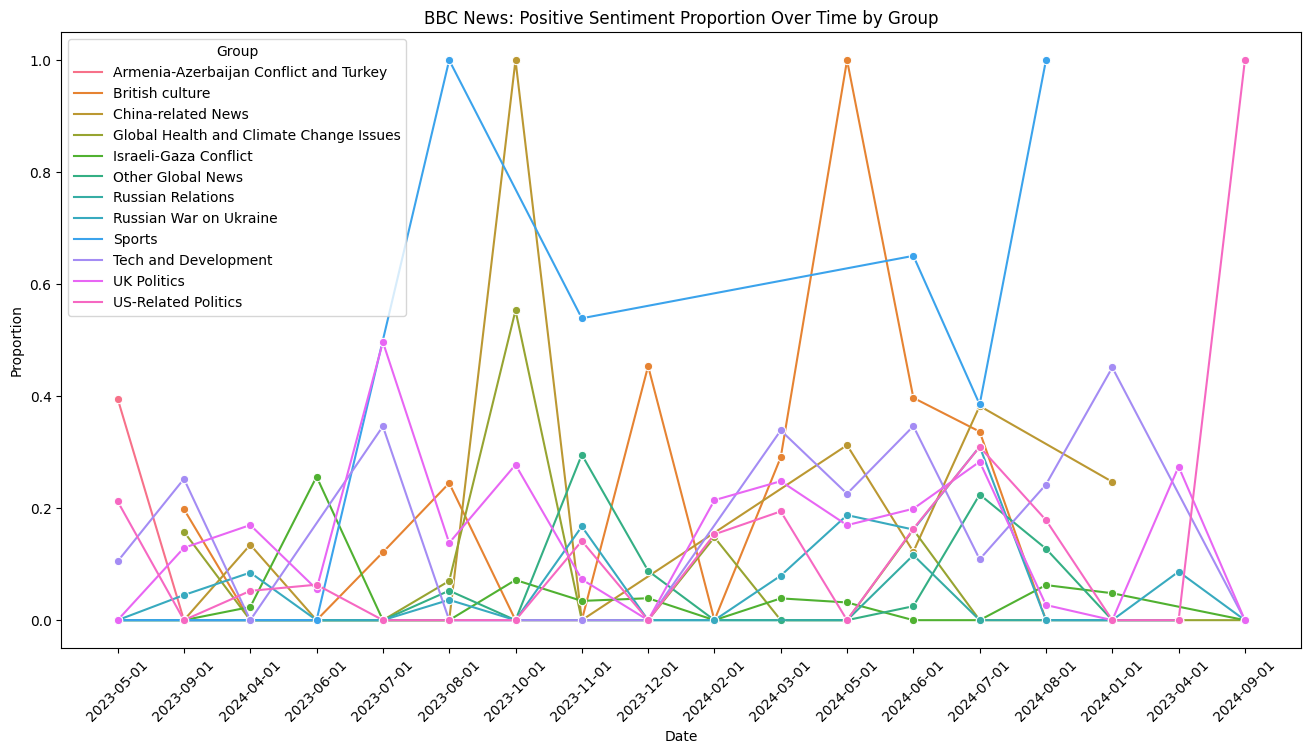

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(data=grouped_sentiment, x='Date', y='Positive_Proportion', hue='Group', marker='o')
plt.title('BBC News: Positive Sentiment Proportion Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.show()

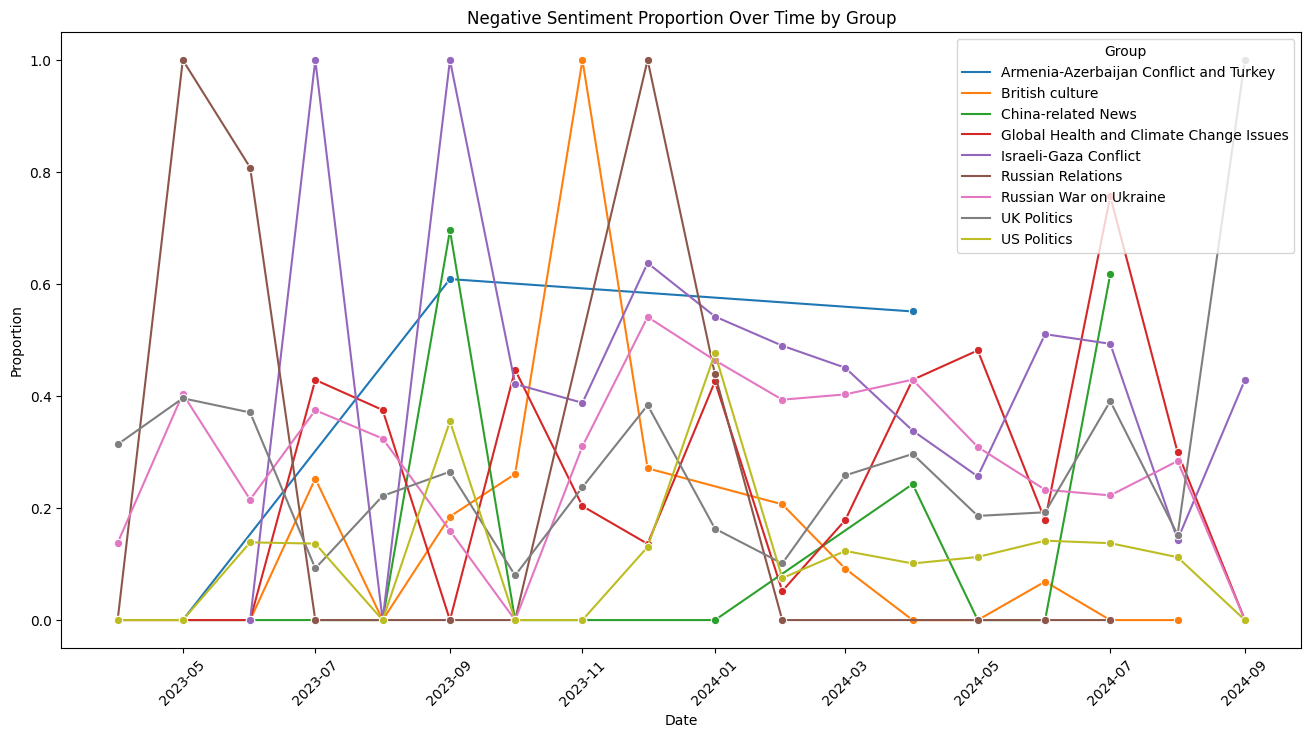

In [73]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=grouped_sentiment, x='Date', y='Negative_Proportion', hue='Group', marker='o')
plt.title('Negative Sentiment Proportion Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

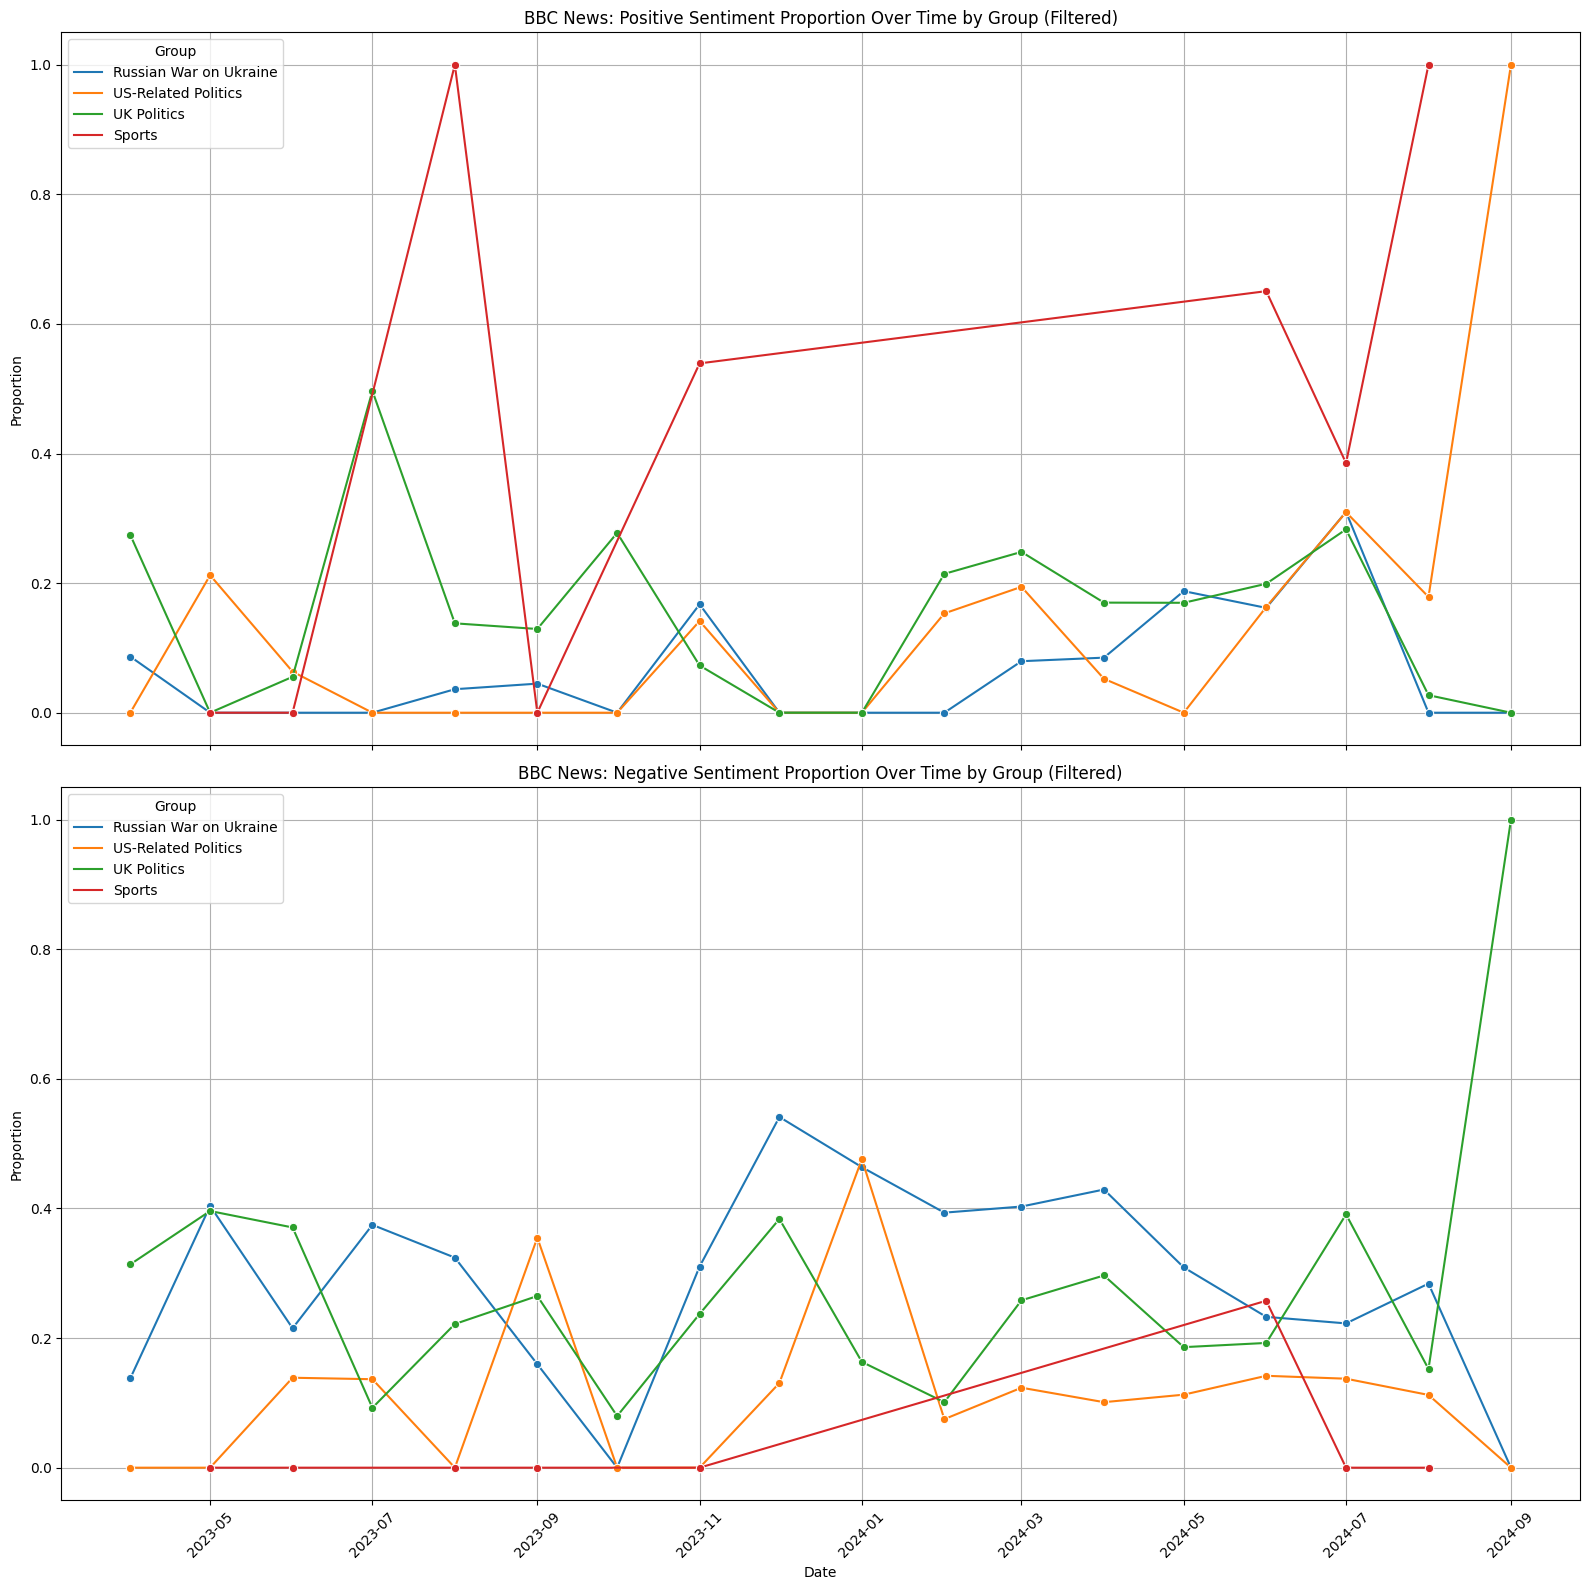

In [18]:
# Plotting the Negative and Positive sentiments over time by group
grouped_sentiment['Date'] = pd.to_datetime(grouped_sentiment['Date'])
grouped_sentiment = grouped_sentiment.sort_values('Date')
selected_groups = ["Russian War on Ukraine", "US-Related Politics", "UK Politics", "Sports"]
filtered_data = grouped_sentiment[grouped_sentiment['Group'].isin(selected_groups)]
filtered_data = grouped_sentiment[(grouped_sentiment['Date'] >= min_date) & 
                                  (grouped_sentiment['Group'].isin(selected_groups))]
fig, axes = plt.subplots(2, 1, figsize=(16, 16), sharex=True)

# Positive Sentiment
sns.lineplot(data=filtered_data, x='Date', y='Positive_Proportion', hue='Group', marker='o', ax=axes[0])
axes[0].set_title('BBC News: Positive Sentiment Proportion Over Time by Group (Filtered)')
axes[0].set_ylabel('Proportion')
axes[0].legend(title='Group')
axes[0].grid(True)

# Negative Sentiment
sns.lineplot(data=filtered_data, x='Date', y='Negative_Proportion', hue='Group', marker='o', ax=axes[1])
axes[1].set_title('BBC News: Negative Sentiment Proportion Over Time by Group (Filtered)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Group')
axes[1].grid(True)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("bbc_sentiment_over_time.png", dpi=300, bbox_inches='tight')
plt.show()

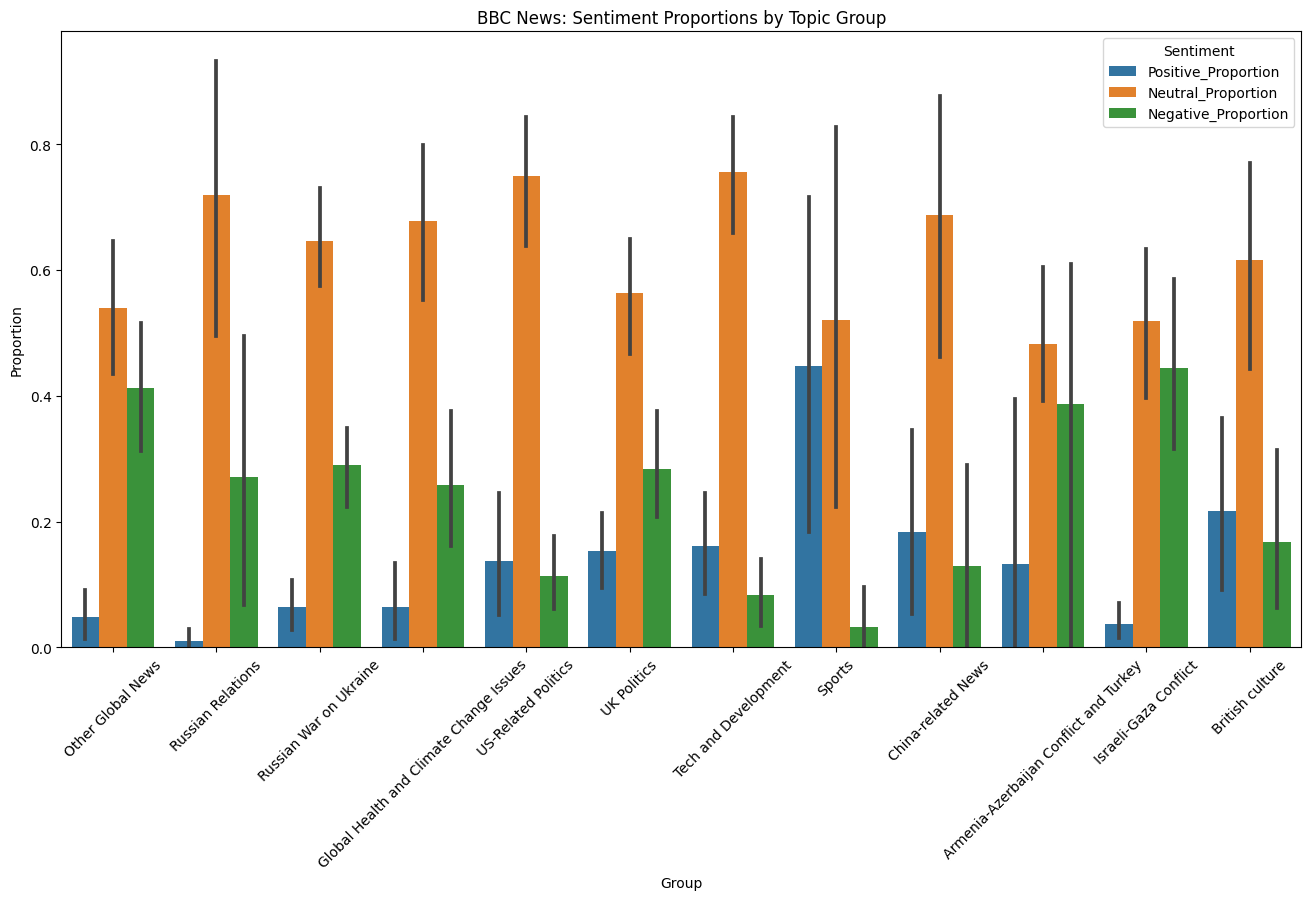

In [20]:
grouped_sentiment_long = grouped_sentiment.melt(
    id_vars=['Group'], 
    value_vars=['Positive_Proportion', 'Neutral_Proportion', 'Negative_Proportion'],
    var_name='Sentiment', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(data=grouped_sentiment_long, x='Group', y='Proportion', ax=ax, hue='Sentiment')
plt.title('BBC News: Sentiment Proportions by Topic Group')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Sentiment')
plt.savefig("bbc_sentiment_distr.png", dpi=300, bbox_inches='tight')
plt.show()

### Summary Table

In [21]:
selected_topics = ["Sports", "Russian War on Ukraine", "US-Related Politics", "UK Politics"]
filtered_data = grouped_sentiment[grouped_sentiment['Group'].isin(selected_topics)]

# Computing the averages
sentiment_averages = filtered_data.groupby('Group')[
    ['Positive_Proportion','Negative_Proportion']
].mean().reset_index()

news_by_metrics = sentiment_averages
news_by_metrics = news_by_metrics.rename(columns={
    'Positive_Proportion': 'Positive Sentiment',
    'Negative_Proportion': 'Negative Sentiment'
})

In [23]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc_summary_table.csv')

In [67]:
news_by_metrics

,Group,Positive Sentiment,Negative Sentiment
0,Russian War on Ukraine,0.064376,0.289184
1,Sports,0.446861,0.032204
2,UK Politics,0.153046,0.283409
3,US-Related Politics,0.137117,0.113357


## Emotion Analysis

In [187]:
exploded_data_for_modeling = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_scores.csv")

In [188]:
emotion_analysis_data = exploded_data_for_modeling.filter(['Date','Chunks','Processed_Chunks', 
                                                          'Assigned_Topic_ID', 'Assigned_Topic_Name',
                                                          'Group'], axis=1)
emotion_analysis_data

,Date,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Group
0,2023-04-01,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict,Russian War on Ukraine
1,2023-04-01,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict,Russian War on Ukraine
2,2023-04-01,Sudan's army has accused its rival paramilitar...,Sudan's army accused rival paramilitary rapid ...,17,Sudanese Conflict and Civil War,Other Global News
3,2023-04-01,Your live with BBC News. The European Space Ag...,News. European Space Agency's disabled astrona...,-1,UK Children's Safety News,UK Politics
4,2023-04-01,physical disability to go to space and address...,physical disability space address issues hopef...,-1,UK Children's Safety News,UK Politics
...,...,...,...,...,...,...
2018,2024-09-01,at this sort of scale. What we really would ne...,sort scale. diverse technology industry. compa...,27,Cybersecurity and Software Updates,Tech and Development
2019,2024-09-01,World leaders are gathering in New York for th...,World leaders gathering York 79th session Gene...,1,Russian-Ukrainian Political Conflict,Russian War on Ukraine
2020,2024-09-01,The powerful Lebanese militant group Hezbollah...,powerful Lebanese militant group Hezbollah it'...,0,Israel-Gaza Conflict,Israeli-Gaza Conflict
2021,2024-09-01,its operation. This very intense aerial bombar...,operation. intense aerial bombardment assessme...,0,Israel-Gaza Conflict,Israeli-Gaza Conflict


In [189]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Loading the emotion classifier from hugging face
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# classifying emotions and extracting scores
def classify_emotions(text):
    try:
        results = classifier(text)
        scores = {result['label']: result['score'] for result in results[0]}
        return scores
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {}

tqdm.pandas()
emotion_analysis_data['Emotion_Scores'] = emotion_analysis_data['Processed_Chunks'].progress_apply(classify_emotions)

# Splitting the emotions disctionary inot different columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
for emotion in emotion_columns:
    emotion_analysis_data[f'{emotion}_score'] = emotion_analysis_data['Emotion_Scores'].apply(lambda x: x.get(emotion, None))
emotion_analysis_data.drop(columns=['Emotion_Scores'], inplace=True)

print(emotion_analysis_data.head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
 14%|█████▌                                  | 282/2023 [00:15<01:31, 19.08it/s]

Error processing text: Los tartezos eran, digamos, el producto entre la U... - The expanded size of the tensor (954) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 954].  Tensor sizes: [1, 514]


 18%|███████▍                                | 373/2023 [00:19<01:15, 21.87it/s]

Error processing text: אותen hon, Dysgryni cynneudioiad, ac gallu eu mith... - The expanded size of the tensor (1062) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1062].  Tensor sizes: [1, 514]


 30%|████████████                            | 609/2023 [00:30<01:08, 20.78it/s]

Error processing text: جو هديتو تو ببطاليا تبها أحب أنا جمان عماد صحفي مق... - The expanded size of the tensor (1287) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1287].  Tensor sizes: [1, 514]


 32%|████████████▊                           | 646/2023 [00:32<00:52, 26.39it/s]

Error processing text: Chr press planteus※ o lefon,ydd cylsích d theyiesi... - The expanded size of the tensor (1123) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1123].  Tensor sizes: [1, 514]
Error processing text: Ysbryrgenau rehal woofrio 🐤 Mae fy doubtデwyyth?发 d... - The expanded size of the tensor (1198) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1198].  Tensor sizes: [1, 514]


 37%|██████████████▉                         | 754/2023 [00:37<00:52, 24.25it/s]

Error processing text: Sono italiano, sono Christiana! OFL LA OKR Irino è... - The expanded size of the tensor (1018) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1018].  Tensor sizes: [1, 514]
Error processing text: l' didnito. ma Valentina, Danielello Catarina, dau... - The expanded size of the tensor (907) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 907].  Tensor sizes: [1, 514]
Error processing text: super consciente che broth invalidiamoуска, vois f... - The expanded size of the tensor (521) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 521].  Tensor sizes: [1, 514]


 46%|██████████████████▎                     | 929/2023 [00:46<00:50, 21.87it/s]

Error processing text: 17 taulic fra G Leben Goatwa HinifatidolG, Ym o Sc... - The expanded size of the tensor (802) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 802].  Tensor sizes: [1, 514]


 53%|████████████████████▊                  | 1079/2023 [00:53<00:44, 21.05it/s]

Error processing text: 이 한국이라는 사회는 혼자서도 갚박한데 이인을 어떻게 만들어? 한국에서 날 귀엽다. 플랫.... - The expanded size of the tensor (3005) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 3005].  Tensor sizes: [1, 514]


 54%|█████████████████████                  | 1093/2023 [00:54<00:47, 19.56it/s]

Error processing text: Lest yr yserau os ffavodd gynylltu sy'n gyněn b di... - The expanded size of the tensor (1135) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1135].  Tensor sizes: [1, 514]


 64%|████████████████████████▊              | 1287/2023 [01:03<00:27, 26.67it/s]

Error processing text: Marour ar ddim creu edrych wedi arddyn gweith? Mae... - The expanded size of the tensor (752) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 752].  Tensor sizes: [1, 514]


 87%|█████████████████████████████████▋     | 1750/2023 [01:26<00:11, 23.25it/s]

Error processing text: Uthorytieth finnew polynomial fel darwch warmethiw... - The expanded size of the tensor (941) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 941].  Tensor sizes: [1, 514]


 89%|██████████████████████████████████▌    | 1794/2023 [01:28<00:10, 22.43it/s]

Error processing text: Ilaynag Divorru ni dy Sue y ni Llym Ar Lords yr o'... - The expanded size of the tensor (655) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 655].  Tensor sizes: [1, 514]


100%|███████████████████████████████████████| 2023/2023 [01:40<00:00, 20.21it/s]

         Date                                             Chunks  \
0  2023-04-01  The group has begun a three-day official visit...   
1  2023-04-01  from the cathedral in the capital Budapest. We...   
2  2023-04-01  Sudan's army has accused its rival paramilitar...   
3  2023-04-01  Your live with BBC News. The European Space Ag...   
4  2023-04-01  physical disability to go to space and address...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  group begun three-day official visit Hungary, ...                  1   
1  cathedral capital Budapest. bring you, course,...                  1   
2  Sudan's army accused rival paramilitary rapid ...                 17   
3  News. European Space Agency's disabled astrona...                 -1   
4  physical disability space address issues hopef...                 -1   

                    Assigned_Topic_Name                   Group  anger_score  \
0  Russian-Ukrainian Political Conflict  Russian War on Ukra

In [190]:
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)
emotion_analysis_data['Final_Emotion_Score'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].max(axis=1)

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/1450040514.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)


In [191]:
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data['Final_Emotion'].str.replace('_score', '', regex=False)
emotion_analysis_data.head()

,Date,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Group,anger_score,disgust_score,fear_score,joy_score,neutral_score,sadness_score,surprise_score,Final_Emotion,Final_Emotion_Score
0,2023-04-01,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict,Russian War on Ukraine,0.038806,0.003535,0.720822,0.050620,0.107440,0.025531,0.053246,fear,0.720822
1,2023-04-01,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict,Russian War on Ukraine,0.002959,0.001081,0.003259,0.208878,0.626899,0.045171,0.111752,neutral,0.626899
2,2023-04-01,Sudan's army has accused its rival paramilitar...,Sudan's army accused rival paramilitary rapid ...,17,Sudanese Conflict and Civil War,Other Global News,0.004223,0.000550,0.002084,0.002268,0.003344,0.981761,0.005770,sadness,0.981761
3,2023-04-01,Your live with BBC News. The European Space Ag...,News. European Space Agency's disabled astrona...,-1,UK Children's Safety News,UK Politics,0.001933,0.000416,0.001045,0.848727,0.024505,0.017952,0.105422,joy,0.848727
4,2023-04-01,physical disability to go to space and address...,physical disability space address issues hopef...,-1,UK Children's Safety News,UK Politics,0.009809,0.001452,0.032995,0.064516,0.220006,0.008347,0.662875,surprise,0.662875


In [31]:
emotion_analysis_data.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_emotion_dataset.csv")

In [192]:
# Groupping the data by topics and the date
grouped_emotion = emotion_analysis_data.groupby(['Group', 'Date'])[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].mean().reset_index()

In [193]:
# Calculating the proportions of each emotion scores
grouped_emotion['Total_Score'] = grouped_emotion[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].sum(axis=1)
grouped_emotion['anger_Proportion'] = grouped_emotion['anger_score'] / grouped_emotion['Total_Score']
grouped_emotion['disgust_Proportion'] = grouped_emotion['disgust_score'] / grouped_emotion['Total_Score']
grouped_emotion['fear_Proportion'] = grouped_emotion['fear_score'] / grouped_emotion['Total_Score']
grouped_emotion['joy_Proportion'] = grouped_emotion['joy_score'] / grouped_emotion['Total_Score']
grouped_emotion['neutral_Proportion'] = grouped_emotion['neutral_score'] / grouped_emotion['Total_Score']
grouped_emotion['sadness_Proportion'] = grouped_emotion['sadness_score'] / grouped_emotion['Total_Score']
grouped_emotion['surprise_Proportion'] = grouped_emotion['surprise_score'] / grouped_emotion['Total_Score']

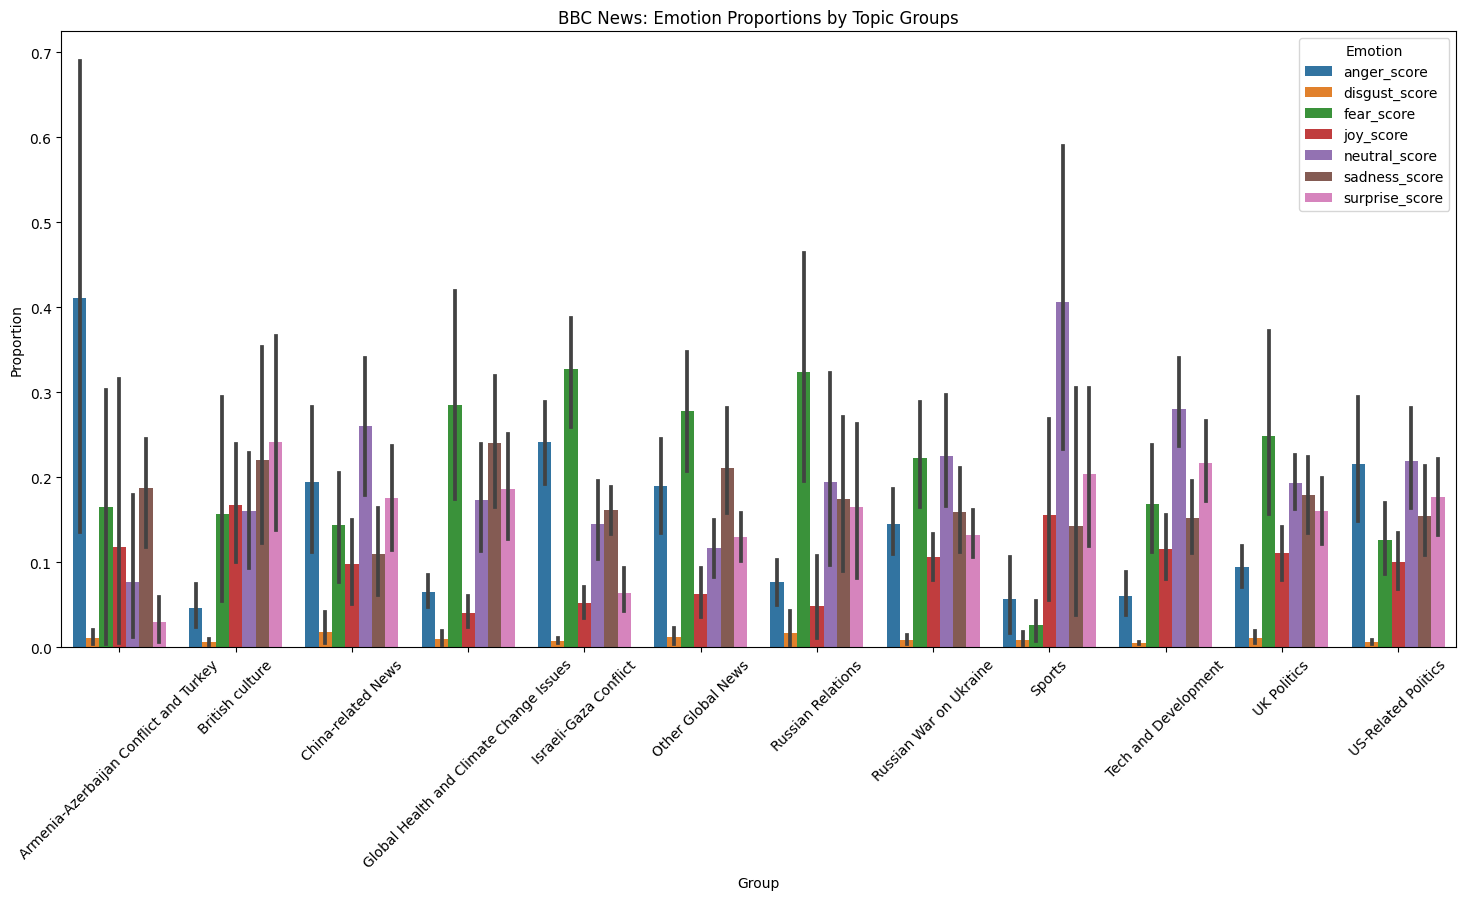

In [194]:
# Plotting the bar chart of every topic group and emotion
grouped_emotion_long = grouped_emotion.melt(
    id_vars=['Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('BBC News: Emotion Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

In [200]:
# Keeping only the needed topics since the visualisation above is crowded
topics_to_keep = ['Sports', "UK Politics", "US-Related Politics", "Russian War on Ukraine"]
grouped_emotion_filtered = grouped_emotion[grouped_emotion['Group'].isin(topics_to_keep)]

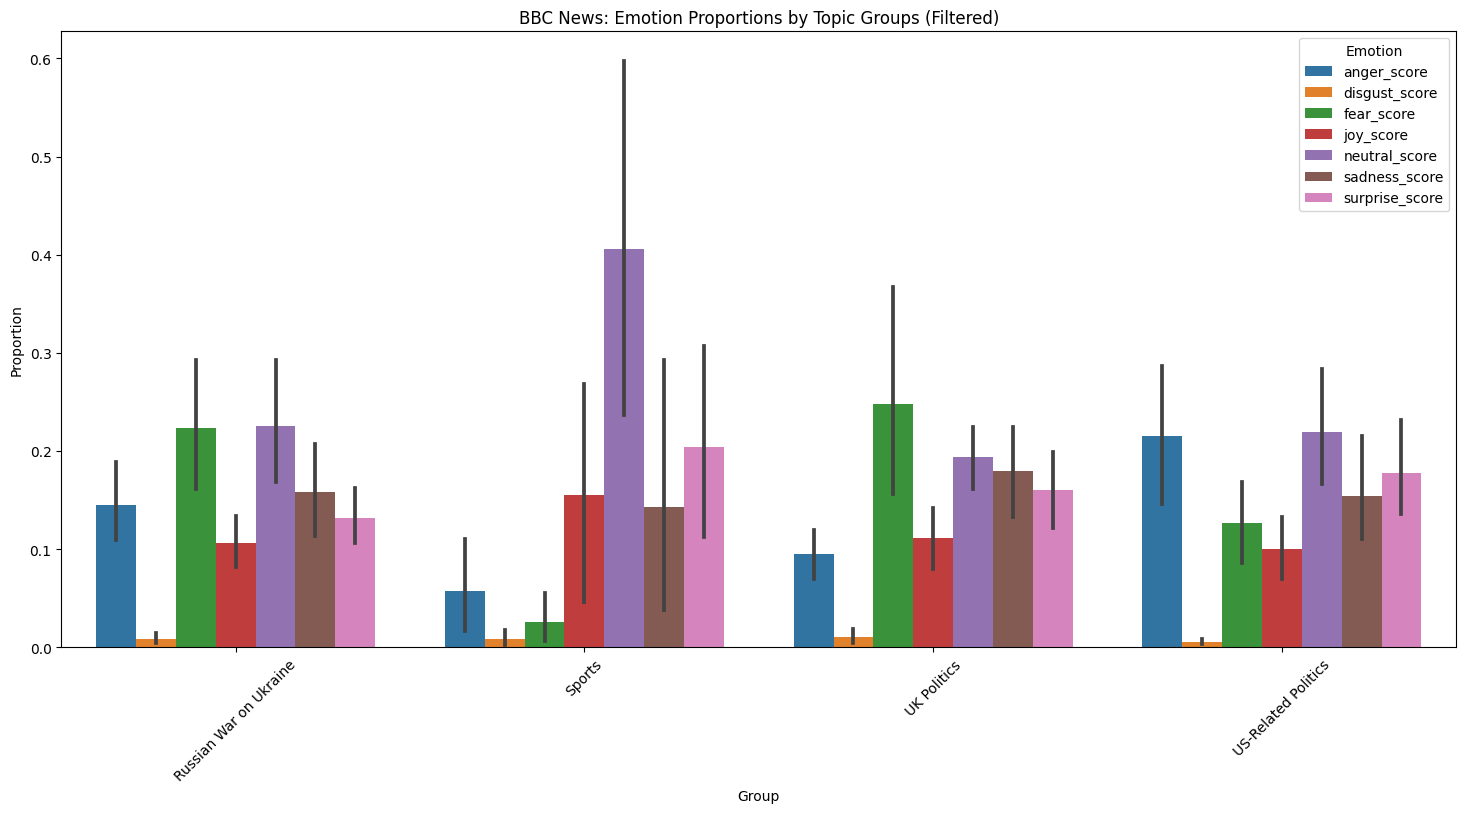

In [43]:
# Plotting the bar chart of every topic group and emotion
grouped_emotion_long = grouped_emotion_filtered.melt(
    id_vars=['Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('BBC News: Emotion Proportions by Topic Groups (Filtered)')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

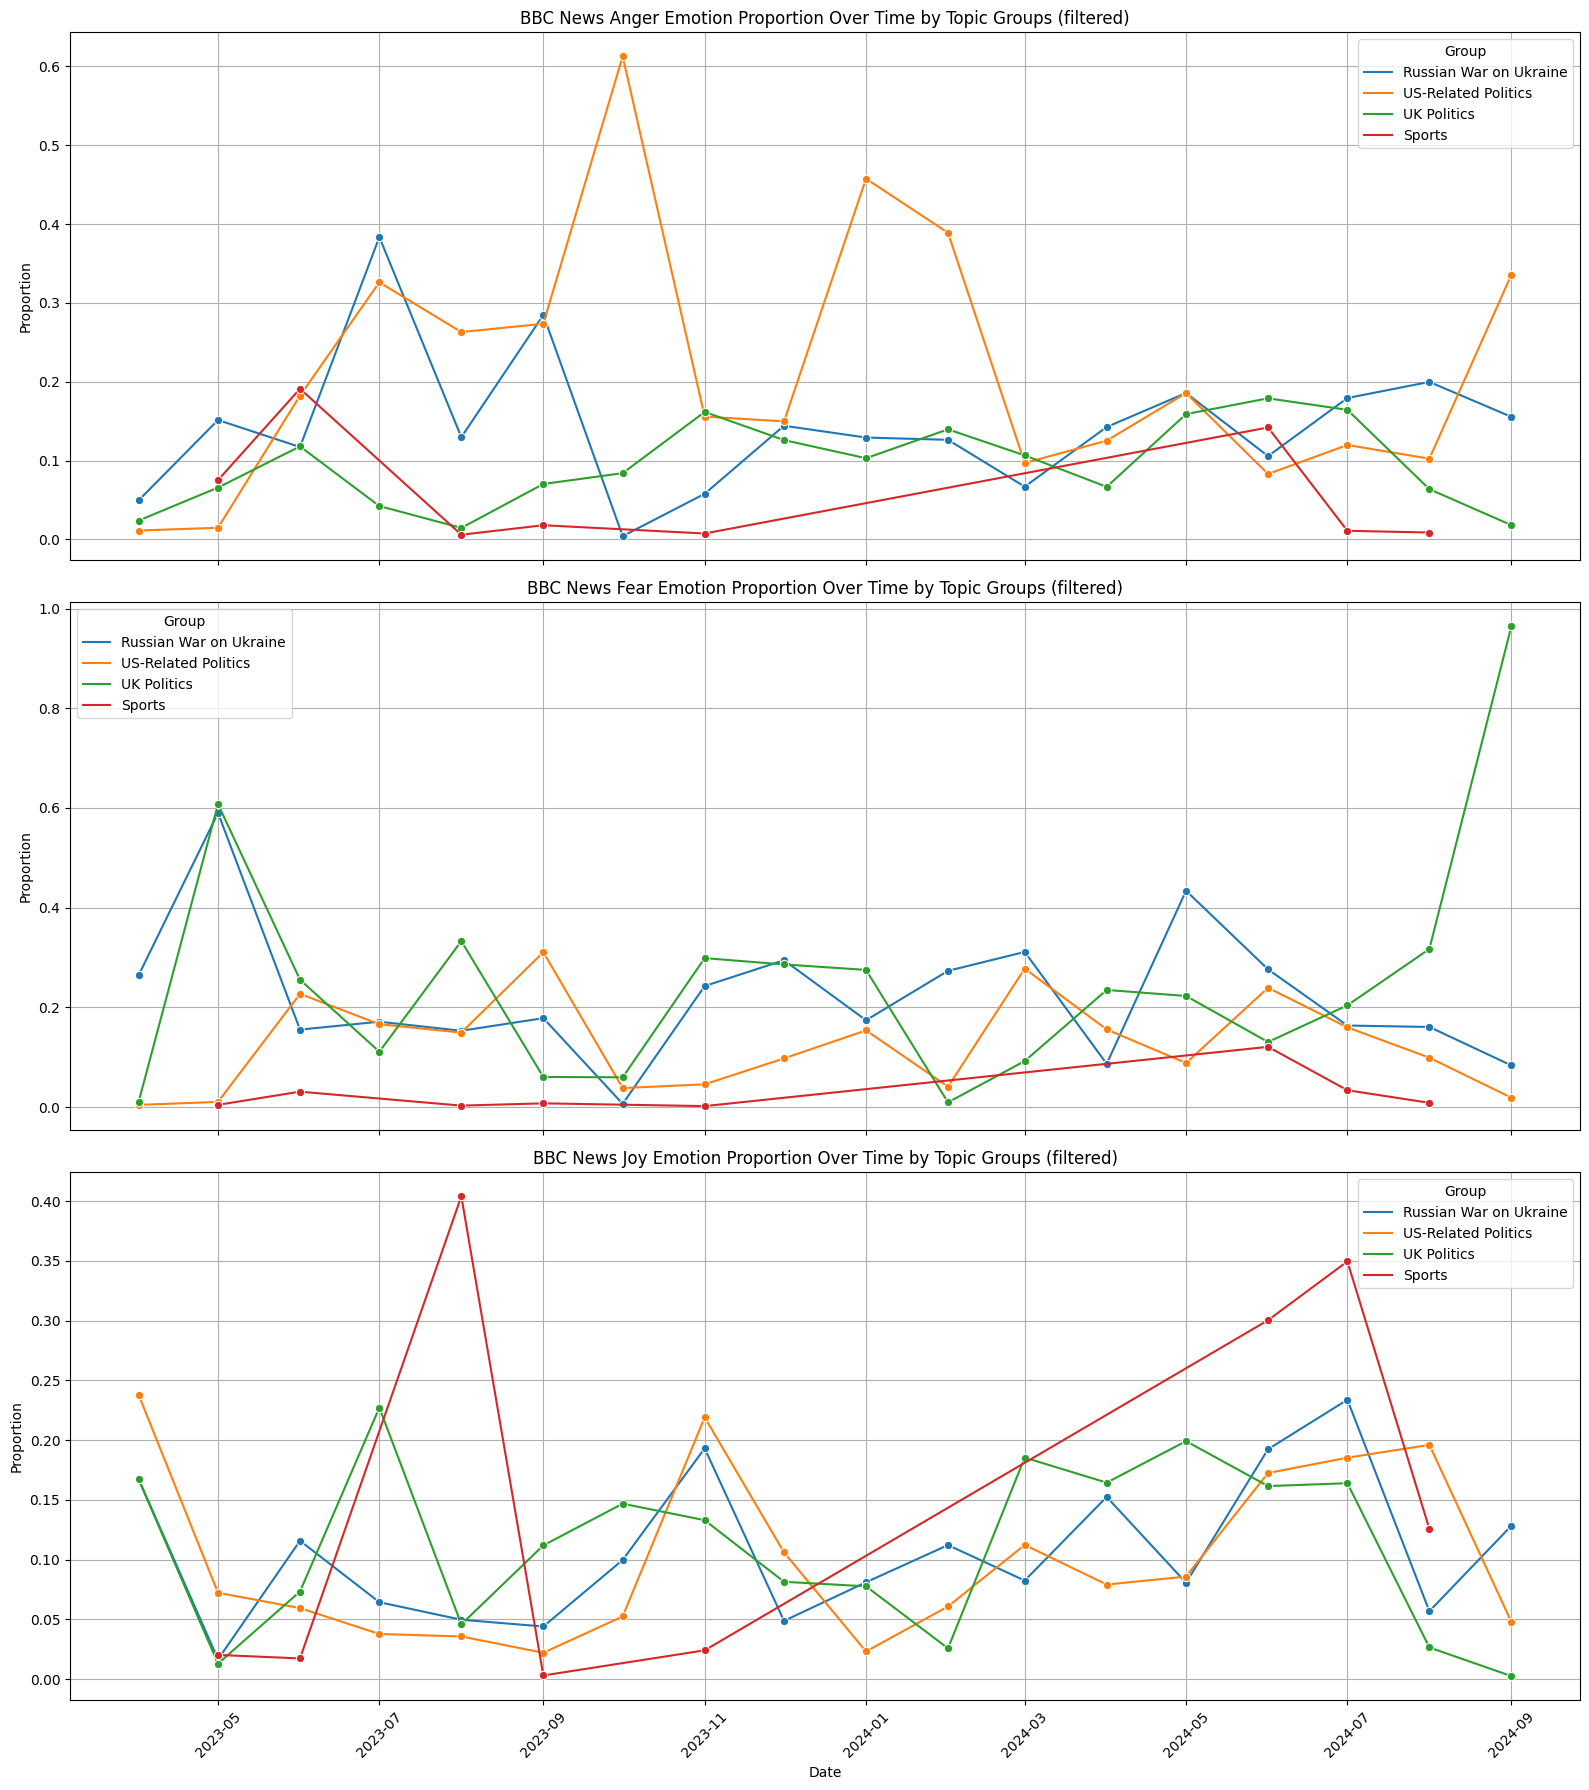

In [48]:
grouped_emotion_filtered = grouped_emotion_filtered.sort_values('Date')
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)


# Define the emotions and titles
emotions = ['anger_score', 'fear_score', 'joy_score']
titles = ['Anger Emotion Proportion Over Time', 
          'Fear Emotion Proportion Over Time', 
          'Joy Emotion Proportion Over Time']

for i, (emotion, title) in enumerate(zip(emotions, titles)):
    sns.lineplot(data=grouped_emotion_filtered, x='Date', y=emotion, hue='Group', marker='o', ax=axes[i])
    axes[i].set_title(f'BBC News {title} by Topic Groups (filtered)')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Group')
    axes[i].grid(True)

    axes[-1].set_xlabel('Date')
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.savefig("bbc_news_emotions_over_time.png", dpi=300, bbox_inches='tight')
plt.show()

## Russian War on Ukraine

### BBC: Emotion

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/442961474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_emotion_filtered['Date'] = pd.to_datetime(grouped_emotion_filtered['Date'])
/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/442961474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_emotion_filtered['Date'] = pd.to_datetime(grouped_emotion_filtered['Date'])
/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/442961474.py:10: Settin

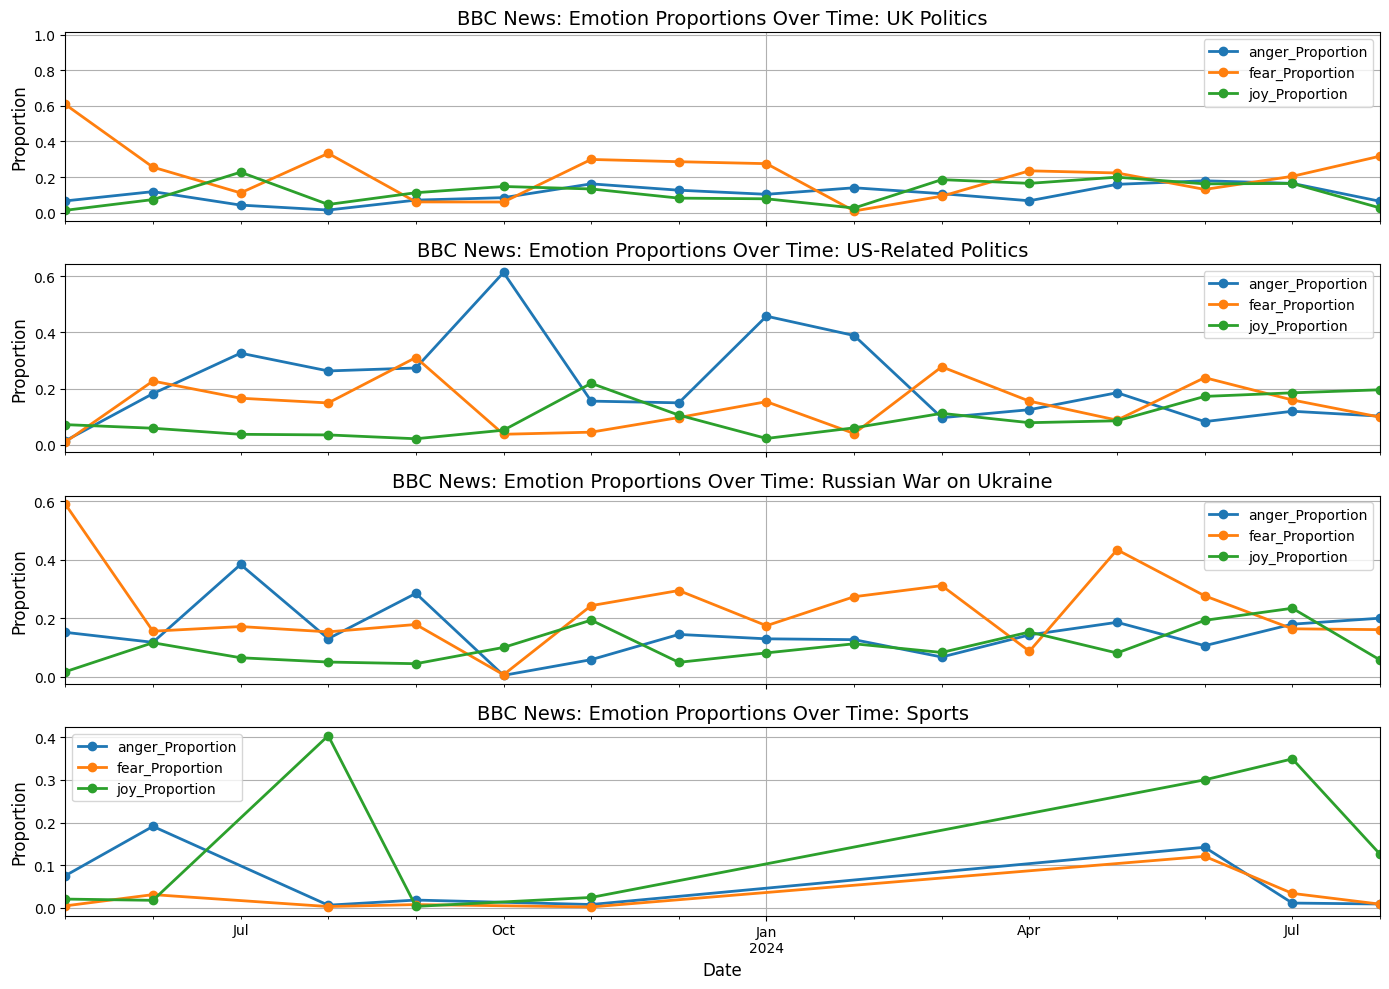

In [205]:
# Define the topics and emotions of interest
topics = ['UK Politics', 'US-Related Politics', 'Russian War on Ukraine', 'Sports']
emotion_columns = ["anger_Proportion", "fear_Proportion", "joy_Proportion"]

fig, axes = plt.subplots(len(topics), 1, figsize=(14, 10), sharex=True)
if len(topics) == 1:
    axes = [axes]

for i, topic in enumerate(topics):
    grouped_emotion_filtered['Date'] = pd.to_datetime(grouped_emotion_filtered['Date'])
    topic_data = grouped_emotion_filtered[grouped_emotion_filtered['Group'] == topic].copy()
    topic_data.set_index('Date', inplace=True)

    if not topic_data.empty:
        topic_data[emotion_columns].plot(kind='line', ax=axes[i], marker='o', linewidth=2)
    else:
        axes[i].text(0.5, 0.5, f"No data for {topic}", ha='center', va='center', fontsize=12, color='red')

    axes[i].set_title(f'BBC News: Emotion Proportions Over Time: {topic}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)

plt.xlabel('Date', fontsize=12)
plt.tight_layout()

plt.savefig("bbc_news_emotions_over_time_by_topics.png", dpi=150, bbox_inches='tight')  # Lower DPI
plt.show()

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/2833740363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_emotion_filtered['Date'] = pd.to_datetime(grouped_emotion_filtered['Date'], errors='coerce')


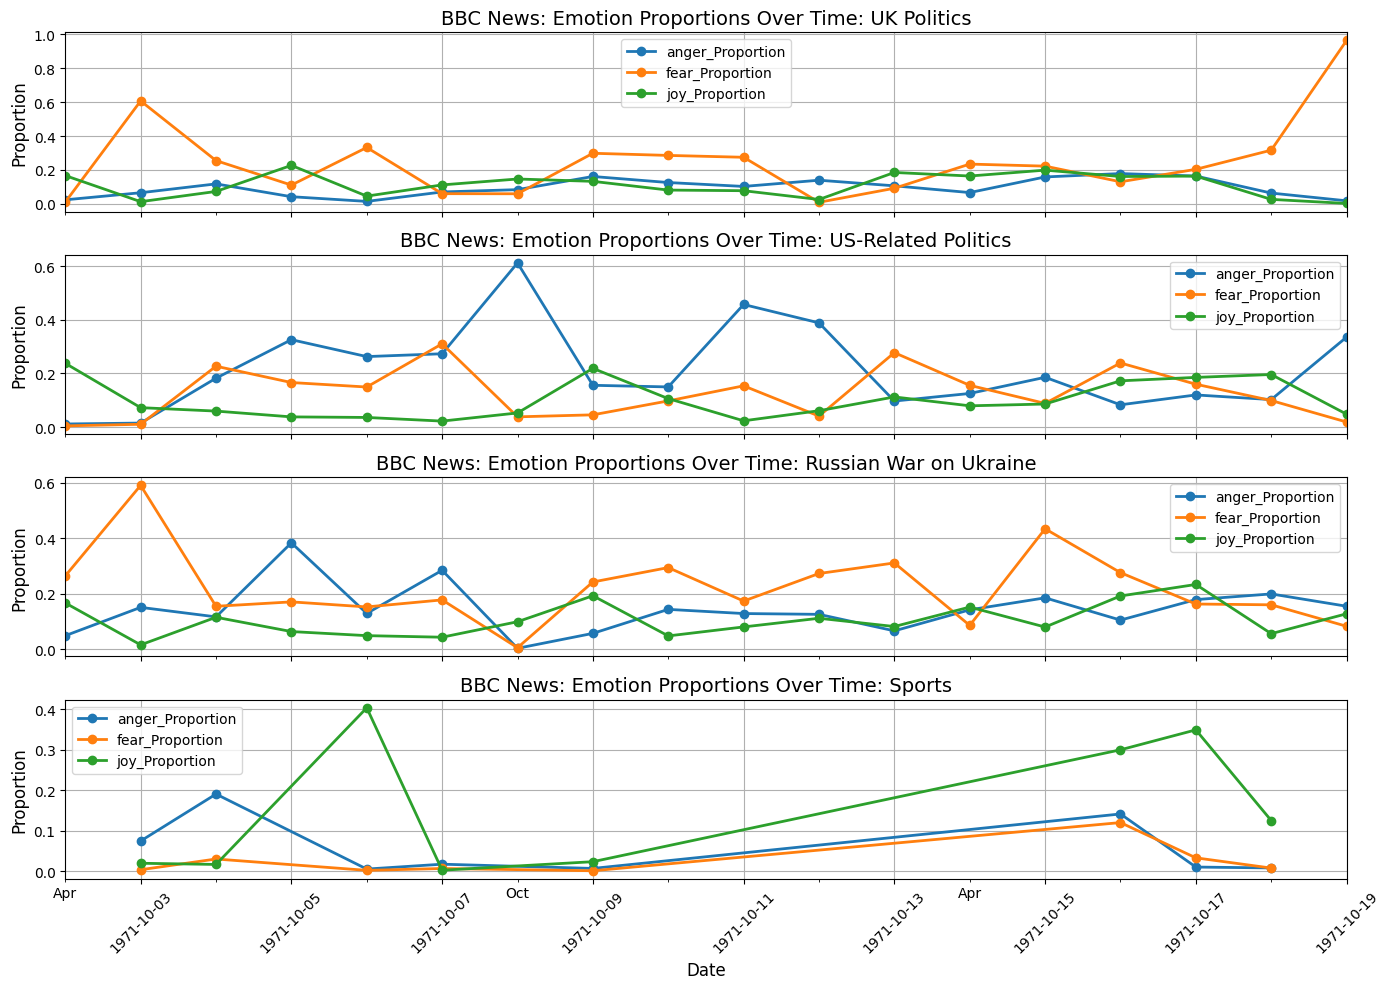

In [203]:
import matplotlib.dates as mdates

# Ensure Date column is properly formatted
grouped_emotion_filtered['Date'] = pd.to_datetime(grouped_emotion_filtered['Date'], errors='coerce')

# Define the topics and emotions of interest
topics = ['UK Politics', 'US-Related Politics', 'Russian War on Ukraine', 'Sports']
emotion_columns = ["anger_Proportion", "fear_Proportion", "joy_Proportion"]

fig, axes = plt.subplots(len(topics), 1, figsize=(14, 10), sharex=True)
if len(topics) == 1:
    axes = [axes]

for i, topic in enumerate(topics):
    topic_data = grouped_emotion_filtered[grouped_emotion_filtered['Group'] == topic].copy()

    # Ensure Date is the index
    topic_data.set_index('Date', inplace=True)

    if not topic_data.empty:
        topic_data[emotion_columns].plot(kind='line', ax=axes[i], marker='o', linewidth=2)
    else:
        axes[i].text(0.5, 0.5, f"No data for {topic}", ha='center', va='center', fontsize=12, color='red')

    axes[i].set_title(f'BBC News: Emotion Proportions Over Time: {topic}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)

    # Format x-axis correctly
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())

    # Ensure correct x-axis limits
    axes[i].set_xlim([grouped_emotion_filtered['Date'].min(), grouped_emotion_filtered['Date'].max()])

plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

### Updating summary table

In [69]:
emotion_columns = ["fear_Proportion", "anger_Proportion", "joy_Proportion"]
emotion_averages = grouped_emotion_filtered.groupby("Group")[emotion_columns].mean().reset_index()
news_by_metrics = news_by_metrics.merge(emotion_averages, on="Group", how="left")

In [72]:
news_by_metrics.rename(columns={
    "fear_Proportion": "Fear Proportion",
    "anger_Proportion": "Anger Proportion",
    "joy_Proportion": "Joy Proportion",
}, inplace=True)

In [161]:
news_by_metrics

,Group,Positive Sentiment,Negative Sentiment,fear_Proportion_x,anger_Proportion_x,joy_Proportion_x
0,Russian War on Ukraine,0.064376,0.289184,0.223257,0.145196,0.106688
1,Sports,0.446861,0.032204,0.026268,0.057464,0.155575
2,UK Politics,0.153046,0.283409,0.248446,0.094833,0.111517
3,US-Related Politics,0.137117,0.113357,0.126751,0.215795,0.100364


In [74]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc_summary_table.csv')

### Bel: Emotion

In [90]:
bel_emotion = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/emotion_dataset.csv")

In [91]:
# Group by topics or time (or both)
grouped_emotion = bel_emotion.groupby(['Group', 'Date'])[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].mean().reset_index()
grouped_emotion['Total_Score'] = grouped_emotion[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].sum(axis=1)
grouped_emotion['anger_Proportion'] = grouped_emotion['anger_score'] / grouped_emotion['Total_Score']
grouped_emotion['disgust_Proportion'] = grouped_emotion['disgust_score'] / grouped_emotion['Total_Score']
grouped_emotion['fear_Proportion'] = grouped_emotion['fear_score'] / grouped_emotion['Total_Score']
grouped_emotion['joy_Proportion'] = grouped_emotion['joy_score'] / grouped_emotion['Total_Score']
grouped_emotion['neutral_Proportion'] = grouped_emotion['neutral_score'] / grouped_emotion['Total_Score']
grouped_emotion['sadness_Proportion'] = grouped_emotion['sadness_score'] / grouped_emotion['Total_Score']
grouped_emotion['surprise_Proportion'] = grouped_emotion['surprise_score'] / grouped_emotion['Total_Score']

In [163]:
# Keeping only the needed topics since the visualisation above is crowded
topics_to_keep = ["Belarusian opposition", "US-Related Politics", "Russian War on Ukraine", 'Sports']
grouped_emotion_filtered = grouped_emotion[grouped_emotion['Group'].isin(topics_to_keep)]

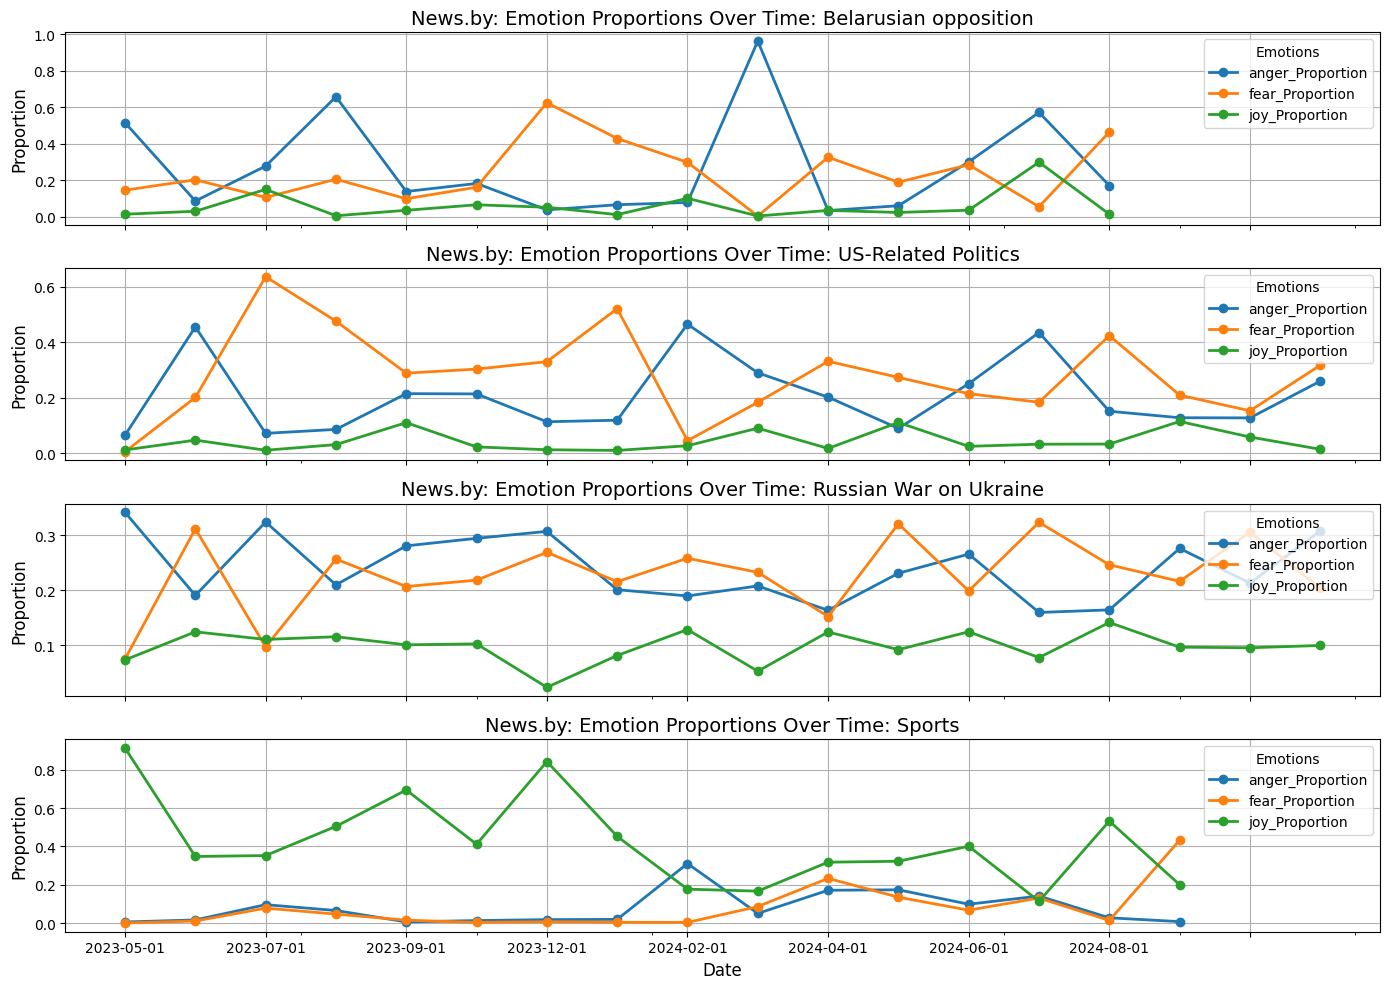

In [166]:
emotion_columns = ["anger_Proportion", "fear_Proportion", "joy_Proportion"]

fig, axes = plt.subplots(len(topics), 1, figsize=(14, 10), sharex=True)
if len(topics) == 1:
    axes = [axes]

for i, topic in enumerate(topics_to_keep):
    topic_data = grouped_emotion_filtered[grouped_emotion_filtered['Group'] == topic].copy()
    topic_data.set_index('Date', inplace=True)

    if not topic_data.empty:
        topic_data[emotion_columns].plot(kind='line', ax=axes[i], marker='o', linewidth=2)
    else:
        axes[i].text(0.5, 0.5, f"No data for {topic}", ha='center', va='center', fontsize=12, color='red')

    axes[i].set_title(f'News.by: Emotion Proportions Over Time: {topic}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)

plt.xlabel('Date', fontsize=12)
for ax in axes:
    ax.legend(title='Emotions', loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("news_by_emotions_over_time_by_topics.png", dpi=300, bbox_inches='tight')
plt.show()

In [213]:
bel_ukraine_war_emotion.head()

,Group,Date,anger_score,disgust_score,fear_score,joy_score,neutral_score,sadness_score,surprise_score,Total_Score,anger_Proportion,disgust_Proportion,fear_Proportion,joy_Proportion,neutral_Proportion,sadness_Proportion,surprise_Proportion
122,Ukraine-Related Topics,April 2023.0,0.341850,0.017013,0.074487,0.072798,0.213144,0.065284,0.215425,1.0,0.341850,0.017013,0.074487,0.072798,0.213144,0.065284,0.215425
123,Ukraine-Related Topics,April 2024.0,0.265732,0.003761,0.198677,0.124095,0.094685,0.182057,0.130992,1.0,0.265732,0.003761,0.198677,0.124095,0.094685,0.182057,0.130992
124,Ukraine-Related Topics,August 2023.0,0.280782,0.009431,0.206631,0.100337,0.161517,0.141762,0.099540,1.0,0.280782,0.009431,0.206631,0.100337,0.161517,0.141762,0.099540
125,Ukraine-Related Topics,August 2024.0,0.212887,0.011405,0.305760,0.094940,0.178574,0.123633,0.072801,1.0,0.212887,0.011405,0.305760,0.094940,0.178574,0.123633,0.072801
126,Ukraine-Related Topics,December 2023.0,0.189448,0.005033,0.258197,0.128128,0.265508,0.096707,0.056978,1.0,0.189448,0.005033,0.258197,0.128128,0.265509,0.096707,0.056978


### Sentiment

In [96]:
ukraine_war_sentiment.head()

,Unnamed: 0,Year,Month,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Date,Group,Positive_Score,Neutral_Score,Negative_Score,Final_Sentiment,Final_Sentiment_Score
0,0,2023,April,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict,2023-04-01,Russian War on Ukraine,0.0,0.866961,0.000000,Neutral_Score,0.866961
1,1,2023,April,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict,2023-04-01,Russian War on Ukraine,0.0,0.789175,0.000000,Neutral_Score,0.789175
7,7,2023,April,"Welcome, it's been a traumatic and terrifying ...","Welcome, it's traumatic terrifying night Ukrai...",1,Russian-Ukrainian Political Conflict,2023-04-01,Russian War on Ukraine,0.0,0.000000,0.811041,Negative_Score,0.811041
8,8,2023,April,know that I think that a number of cities acro...,number cities country hit central southern reg...,1,Russian-Ukrainian Political Conflict,2023-04-01,Russian War on Ukraine,0.0,0.701077,0.000000,Neutral_Score,0.701077
17,17,2023,April,"Live from London, this is BBC News. Now, Ukrai...","London, News. Now, Ukraine's president Zelensk...",1,Russian-Ukrainian Political Conflict,2023-04-01,Russian War on Ukraine,0.0,0.766833,0.000000,Neutral_Score,0.766833


In [95]:
# Filter the DataFrame to only include rows where 'Group' is 'Russian War on Ukraine'
ukraine_war_sentiment = exploded_data_for_modeling[exploded_data_for_modeling['Group'] == 'Russian War on Ukraine']

In [108]:
import matplotlib.pyplot as plt

# List of sentiment proportion columns
sentiment_columns = [
    "Positive_Score", "Neutral_Score", "Negative_Score"
]

# Plot the sentiment proportions as a stacked bar chart
ukraine_war_sentiment[sentiment_columns].plot(
    kind='bar', stacked=True, figsize=(14, 7), width=0.8
)

# Customize the plot
plt.title('Sentiment Proportions Per Date: Russian War on Ukraine', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Proportion', fontsize=14)
plt.legend(title='Sentiments', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Bel: Sentiment

In [128]:
bel_sentiment = pd.read_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/sentiment_dataset.csv')

In [129]:
grouped_sentiment = bel_sentiment.groupby(['Group', 'Date'])[['Positive_Score', 'Neutral_Score', 'Negative_Score']].mean().reset_index()
grouped_sentiment['Total_Score'] = grouped_sentiment[['Positive_Score', 'Neutral_Score', 'Negative_Score']].sum(axis=1)
grouped_sentiment['Positive_Proportion'] = grouped_sentiment['Positive_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Neutral_Proportion'] = grouped_sentiment['Neutral_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Negative_Proportion'] = grouped_sentiment['Negative_Score'] / grouped_sentiment['Total_Score']

In [130]:
bel_ukraine_war_sentiment = grouped_sentiment[grouped_sentiment['Group'] == 'Ukraine-Related Topics']

In [ ]:
import matplotlib.pyplot as plt

# List of sentiment proportion columns
sentiment_columns = [
    "Positive_Score", "Neutral_Score", "Negative_Score"
]
# Plot the sentiment proportions as a stacked bar chart
bel_ukraine_war_sentiment[sentiment_columns].plot(
    kind='bar', stacked=True, figsize=(14, 7), width=0.8
)

# Customize the plot
plt.title('Sentiment Proportions Per Date: Russian War on Ukraine', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Proportion', fontsize=14)
plt.legend(title='Sentiments', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Perplexity Comparison

In [109]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.manual_seed(42)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def calculate_perplexity_first_1024(text):
    """Calculate perplexity using the first 1024 tokens of the text."""
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)["input_ids"]
    
    with torch.no_grad():
        outputs = model(input_ids=tokens, labels=tokens)
        loss = outputs.loss
        perplexity = torch.exp(loss)
    
    return perplexity.item()

In [123]:
# Applying the perplexity function to the selected topics in the dataframes
emotion_analysis_data.loc[
    emotion_analysis_data["Group"].isin(["Sports", "US-Related Politics", "Russian War on Ukraine", 
                                         "UK Politics"]), "Perplexity"
] = emotion_analysis_data["Chunks"].apply(calculate_perplexity_first_1024)

bel_emotion.loc[
    bel_emotion["Group"].isin(["Sports", "US-Related Politics", "Russian War on Ukraine", 
                               "Belarusian opposition"]), "Perplexity"
] = bel_emotion["Chunks"].apply(calculate_perplexity_first_1024)

In [146]:
max_perplexity_index = emotion_analysis_data['Perplexity'].idxmax()

# Dropping an outlier
emotion_analysis_data = emotion_analysis_data.drop(index=max_perplexity_index)

In [130]:
# Filter out early data points
emotion_analysis_data = emotion_analysis_data[emotion_analysis_data["Date"] >= '2023-04']
bel_emotion = bel_emotion[bel_emotion["Date"] >= '2023-04']

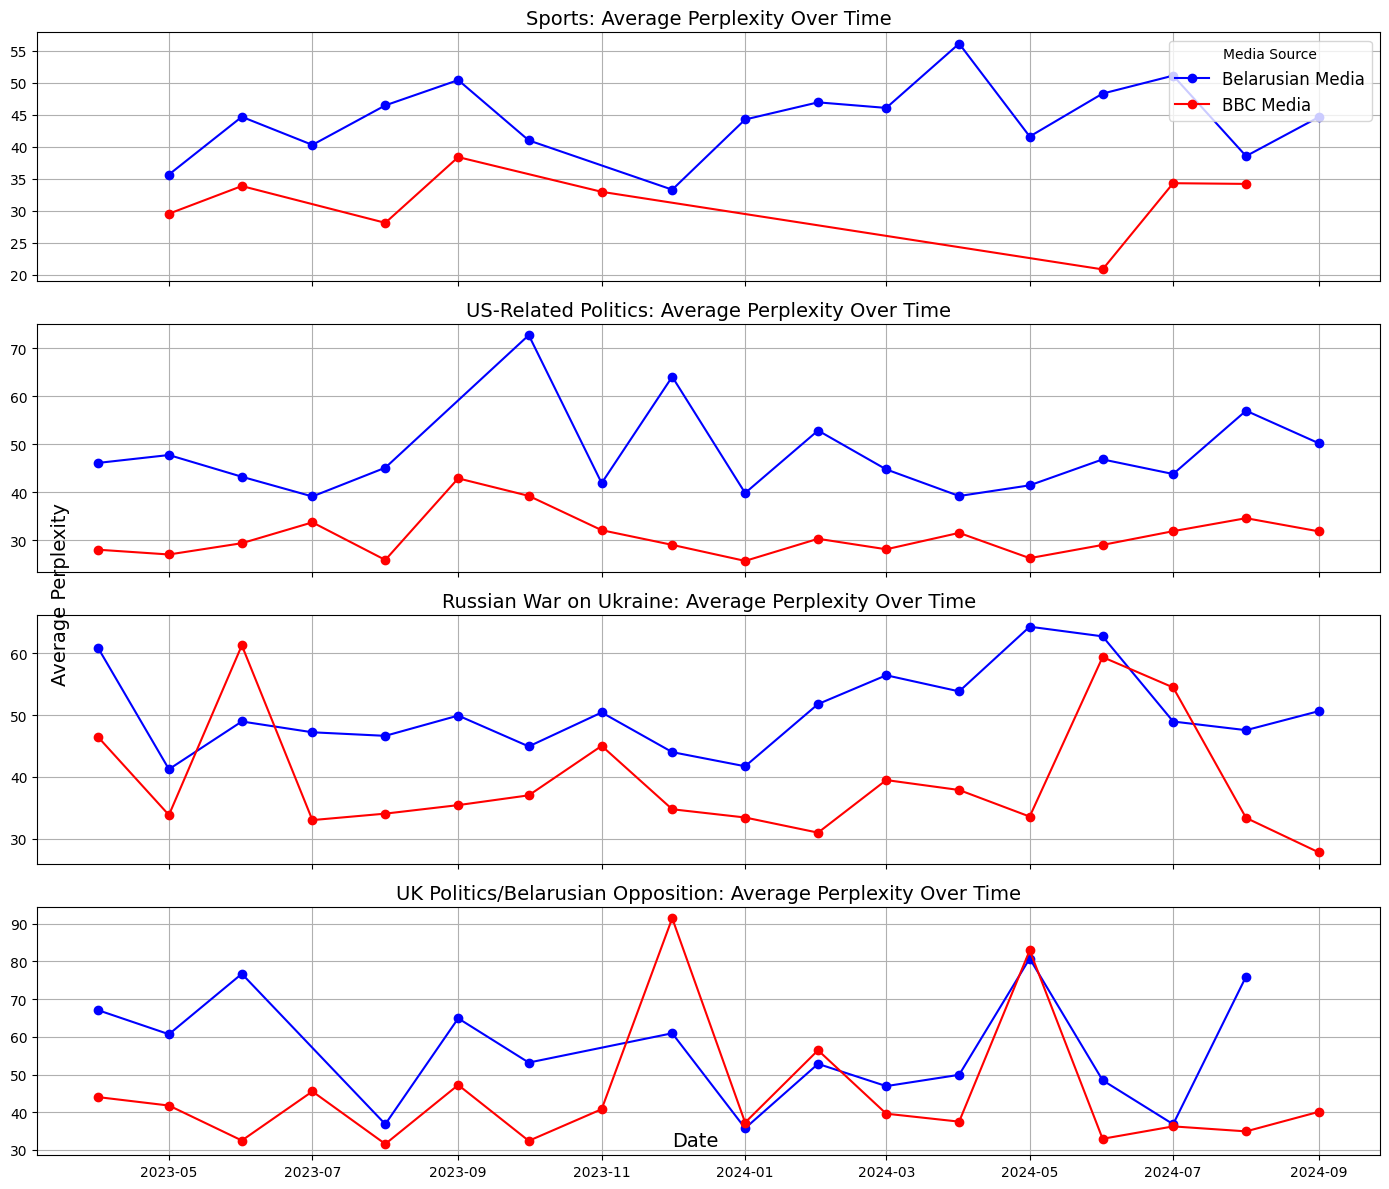

In [148]:
# Ensuring 'Date' columns are datetime
emotion_analysis_data["Date"] = pd.to_datetime(emotion_analysis_data["Date"])
bel_emotion["Date"] = pd.to_datetime(bel_emotion["Date"])
# Standardizing topic names for merging
bel_emotion["Group"] = bel_emotion["Group"].replace({"UK Politics (Belarusian Opposition)": "UK Politics/Belarusian Opposition"})
emotion_analysis_data["Group"] = emotion_analysis_data["Group"].replace({"UK Politics (Belarusian Opposition)": "UK Politics/Belarusian Opposition"})

topics = ["Sports", "US-Related Politics", "Russian War on Ukraine", "UK Politics/Belarusian Opposition"]
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(14, 12))

for i, topic in enumerate(topics):
    ax = axes[i]

    bel_topic_df = bel_emotion[bel_emotion["Group"] == topic].groupby("Date")["Perplexity"].mean().reset_index()
    bbc_topic_df = emotion_analysis_data[emotion_analysis_data["Group"] == topic].groupby("Date")["Perplexity"].mean().reset_index()

    bel_topic_df = bel_topic_df.sort_values(by="Date")
    bbc_topic_df = bbc_topic_df.sort_values(by="Date")

    # Plotting Belarusian media
    ax.plot(
        bel_topic_df["Date"], bel_topic_df["Perplexity"], 
        label="Belarusian Media", color="blue", marker="o"
    )

    # Plotting BBC media
    ax.plot(
        bbc_topic_df["Date"], bbc_topic_df["Perplexity"], 
        label="BBC Media", color="red", marker="o"
    )

    ax.set_title(f"{topic}: Average Perplexity Over Time", fontsize=14)
    ax.grid(True)

fig.text(0.5, 0.04, "Date", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Average Perplexity", va="center", rotation="vertical", fontsize=14)
axes[0].legend(title="Media Source", fontsize=12, loc="upper right")
plt.tight_layout()
plt.savefig("perplexity_topic_comparisons.png", dpi=300, bbox_inches='tight')
plt.show()

## Summary table: perplexity

In [149]:
topics = ["Sports", "US-Related Politics", "Russian War on Ukraine", "UK Politics/Belarusian Opposition"]
summary_data = []

# Calculating mean perplexity
for topic in topics:
    bel_mean = bel_emotion[bel_emotion["Group"] == topic]["Perplexity"].mean()
    bbc_mean = emotion_analysis_data[emotion_analysis_data["Group"] == topic]["Perplexity"].mean()
    summary_data.append([topic, bel_mean, bbc_mean])

summary_df = pd.DataFrame(summary_data, columns=["Topic", "Belarusian Media Perplexity", "BBC Media Perplexity"])

In [152]:
summary_df.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/summary_table_perplexity.csv")